# House Pricing for Ames, IA
## by Otto Roberson

## Preliminary Wrangling

In this project I'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. As a potential home buyer I'm really interested in discovering what factors might help in predicting sales price.

Some factors which I can think of that directly influence house prices include:

- House size
- House age
- Neighborhood or House location
- "Quality" of the house (may be based on many factors)
- Seasonality i.e. the time of year for the sale

I am also interested in further exploration using linear regression in a future project, so I will be using the dataset from the Kaggle platform which can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). 

The original dataset was compiled by [Dean De Cock](http://www.truman.edu/faculty-staff/decock/) for the primary purpose of having a high quality dataset for regression. You can read more about his process and motivation [here](https://doi.org/10.1080/10691898.2011.11889627).

The original dataset is available [here](https://dsserver-prod-resources-1.s3.amazonaws.com/235/AmesHousing.txt), with the corresponding data dictionary [here](http://www.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

The Kaggle data is slightly different from the original. 
- Spaces in column names have been removed. 

Data cleaning
- There is a note from Dean De Cock in the data dictionary related to 5 observations which can be removed by filtering houses with a general living area of more than 4000sq feet. 

- The data for houses sold in 2010 may need to be removed, since the original data didn't include information for the whole year.
 
Kaggle File descriptions:

 - `train.csv` - the training set
 
The following files aren't included in this project but can be downloaded from Kaggle as part of the dataset:

 - `test.csv` - the test set
 - `data_description.txt` - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
 - `sample_submission.csv` - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import scipy.stats as st

import math
import warnings
warnings.filterwarnings('ignore')
import re
import category_encoders as ce
import missingno as msno

Next I will load in the data, right now I will focus on the train file.

In [2]:
#Load in the dataset
train = pd.read_csv("train.csv")

print(train.shape)

(1460, 81)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


I'll take a quick look at the numerical and categorical features next. There might be some which are incorrectly grouped, I'll try to find out further along.

In [4]:
#Look at numerical features
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [5]:
#Look at categorical features
categorical_features = train.select_dtypes(include=[np.object])
categorical_features.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

I'll define a function to work with these, since there are so many and it's hard to keep track of them all.

In [6]:
def get_feature_groups():
    """ Returns a list of numerical and categorical features,
    excluding SalePrice and Id. """
    # Numerical Features
    num_features = train.select_dtypes(include=['int64','float64']).columns
    num_features = num_features.drop(['Id','SalePrice']) # drop ID and SalePrice

    # Categorical Features
    cat_features = train.select_dtypes(include=['object']).columns
    return list(num_features), list(cat_features)

num_features, cat_features = get_feature_groups()

The data dictionary recommends dropping some outliers, I'll do that next. 

In [7]:
# Handle outliers mentioned in the data dictionary
train.drop(train[train.GrLivArea > 4000].index, inplace=True)

I'll take a look at the distribution for the SalePrice:

In [8]:
# What's SalePrice look like
train.SalePrice.describe()

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64

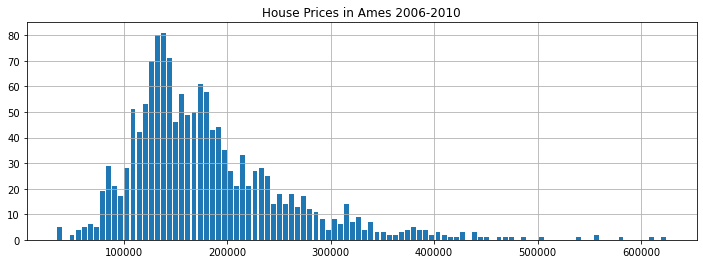

In [9]:
# House prices 
train.SalePrice.hist(bins=100, rwidth=.8, figsize=(12,4))
plt.title('House Prices in Ames 2006-2010')
plt.show()

`SalesPrice` distribution is positively skewed to the right

I'd like to know the age range of the houses in this dataset:

In [10]:
train.YearBuilt.describe()

count    1456.00000
mean     1971.18544
std        30.20159
min      1872.00000
25%      1954.00000
50%      1972.00000
75%      2000.00000
max      2010.00000
Name: YearBuilt, dtype: float64

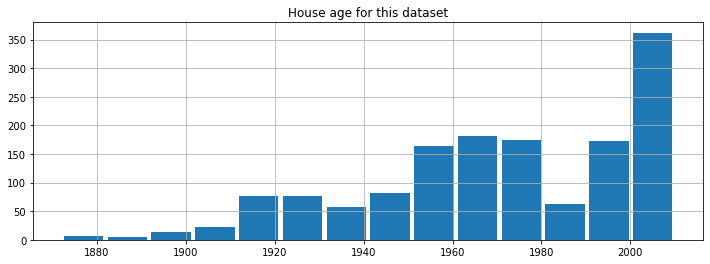

In [11]:
train.YearBuilt.hist(bins=14, rwidth=.9, figsize=(12,4))
plt.title('House age for this dataset')
plt.show()

The majority of houses in the dataset were built post-WWII. 

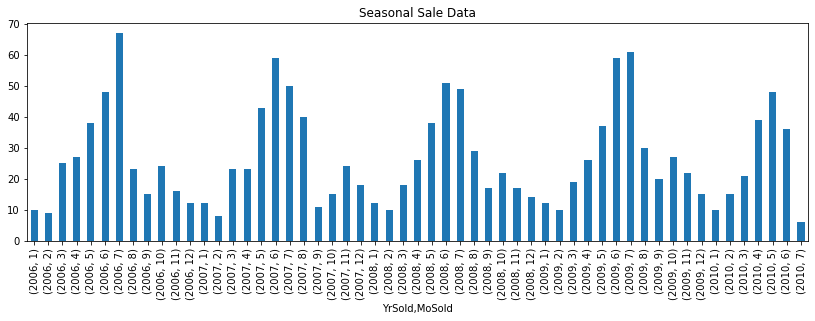

In [12]:
# Group Years and Months of sale to see any seasonality
train.groupby(['YrSold','MoSold']).Id.count().plot(kind='bar', figsize=(14,4))
plt.title('Seasonal Sale Data')
plt.show()

For this dataset, there is a strong seasonal trend with peaks in June and July. The data does not cover the entire 2010 year, so I will drop it.

In [13]:
# Drop incomplete data for 2010 
train.drop(train[(train.YearBuilt > 2009)].index, inplace=True)

In [15]:
#check
train.YearBuilt.describe()

count    1455.000000
mean     1971.158763
std        30.194809
min      1872.000000
25%      1954.000000
50%      1972.000000
75%      2000.000000
max      2009.000000
Name: YearBuilt, dtype: float64

I would like to see a spread of locations, i.e. neighborhoods:

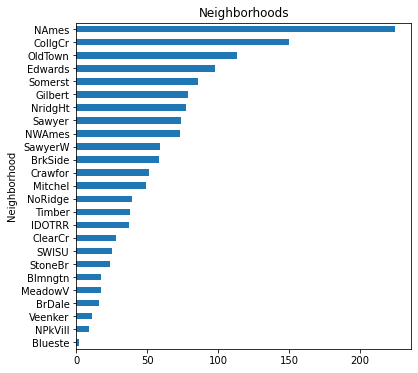

In [16]:
# House location
train.groupby('Neighborhood').Id.count().\
    sort_values().\
    plot(kind='barh', figsize=(6,6))
plt.title('Neighborhoods')
plt.show()

The largest portion of houses is in the North Ames neighborhood, followed by College Creek. It will be interesting to see how this correlates with `SalesPrice`. I'm not familiar with the geography of Ames but have a hunch that there may be some neighborhoods that have higher prices but fewer sales. The age of the neighborhood (i.e. when development began) is also a point to consider. 

I want to see the house size (`GrLivArea`):

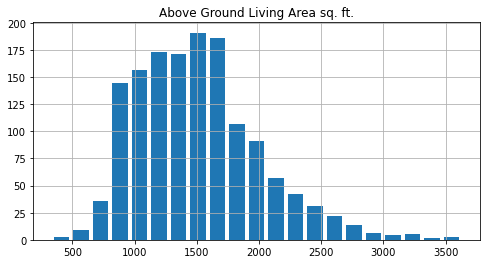

In [17]:
train.GrLivArea.hist(bins=21, rwidth=.8, figsize=(8,4))
plt.title('Above Ground Living Area sq. ft.')
plt.show()

#### Missing Values

In [18]:
#Show the sum of columns with null data
null_columns=train.columns[train.isnull().any()]
train[null_columns].isnull().sum()

LotFrontage      259
Alley           1364
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1450
Fence           1175
MiscFeature     1401
dtype: int64

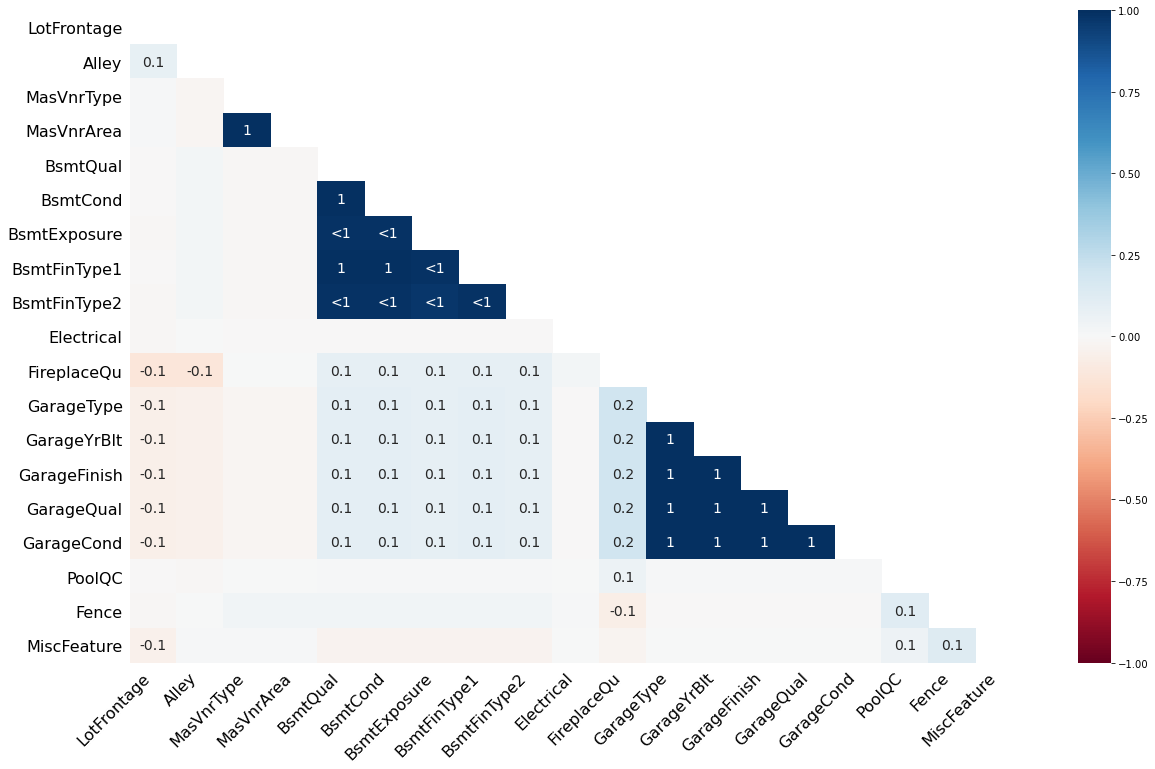

In [19]:
#Heatmap to show correlation between the missing data variables
msno.heatmap(train)

#### Observation: Some of the variables with missing values are strongly correlated.
The correlation in the various `Garage` variables would make sense, because if the garage doesn't exist then the other data shouldn't be there. Possibility to model feature based on these various variables, which I won't do here. I will treat some of the missing values but try to leave the data intact.

We can see a similar case for `Basement` variables. 

In [20]:
#Missing numeric features
num_total = numeric_features.isnull().sum().sort_values(ascending=False)
num_percent = (numeric_features.isnull().sum()/numeric_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([num_total, num_percent], axis=1,join='outer', keys=['Total Missing Count', '% of Total Observations'])
missing_data.index.name =' Numeric Feature'

missing_data.head(12)

,Total Missing Count,% of Total Observations
Numeric Feature,,
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
BsmtFinSF1,0,0.000000
LowQualFinSF,0,0.000000
2ndFlrSF,0,0.000000
1stFlrSF,0,0.000000
TotalBsmtSF,0,0.000000
BsmtUnfSF,0,0.000000


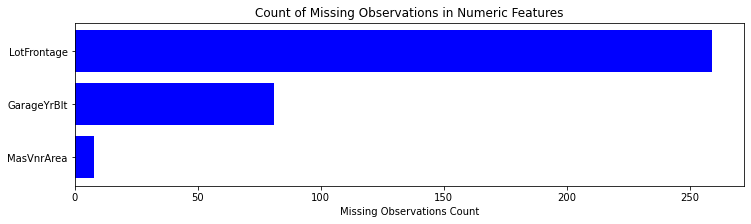

In [21]:
# Plotting missing numeric features
missing_values = numeric_features.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')

ind = np.arange(missing_values.shape[0])
width = 0.1
fig, ax = plt.subplots(figsize=(12,3))
rects = ax.barh(ind, missing_values.missing_count.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing Observations Count")
ax.set_title("Count of Missing Observations in Numeric Features")
plt.show()

In [22]:
#Missing categorical features
cat_total = categorical_features.isnull().sum().sort_values(ascending=False)
cat_percent = (categorical_features.isnull().sum()/categorical_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([cat_total, cat_percent], axis=1,join='outer', keys=['Total Missing Count', ' % of Total Observations'])
missing_data.index.name ='Feature'
missing_data.head(20)

,Total Missing Count,% of Total Observations
Feature,,
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageFinish,81,0.055479
GarageType,81,0.055479


I'll now handle some of the missing values, and transform some of the features which I see should be in other categories:

In [23]:
# Transform categorical features used for rankings
# Also replace missing values with 0

# Alley
train.Alley.replace({'Grvl':1, 'Pave':2}, inplace=True)

# Lot Shape
train.LotShape.replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)

# Land Contour
train.LandContour.replace({'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}, inplace=True)

# Utilities
train.Utilities.replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)

# Land Slope
train.LandSlope.replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)

# Exterior Quality
train.ExterQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Exterior Condition
train.ExterCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Quality
train.BsmtQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Condition
train.BsmtCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Exposure
train.BsmtExposure.replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)

# Finished Basement 1 Rating
train.BsmtFinType1.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Finished Basement 2 Rating
train.BsmtFinType2.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Heating Quality and Condition
train.HeatingQC.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Kitchen Quality
train.KitchenQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Home functionality
train.Functional.replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)

# Fireplace Quality
train.FireplaceQu.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Finish
train.GarageFinish.replace({'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)

# Garage Quality
train.GarageQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Condition
train.GarageCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Paved Driveway
train.PavedDrive.replace({'N':1, 'P':2, 'Y':3}, inplace=True)

# Pool Quality
train.PoolQC.replace({'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Set all missing values in the converted features to 0
converted_features = ['Alley','LotShape','LandContour','Utilities','LandSlope','ExterQual','ExterCond',
        'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
        'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
        'GarageCond','PavedDrive','PoolQC']
train[converted_features] = train[converted_features].fillna(0)

# Update numerical and categorical features
num_features, cat_features = get_feature_groups()

# Fill NA with missing
train[cat_features] = train[cat_features].fillna('Missing')

# Drop other outliers in SalePrice
train.drop(train[train.SalePrice < 38000].index, inplace=True)

# Drop other outliers in Living Area
train.drop(train[train.GrLivArea < 550].index, inplace=True)

# Set missing Electrical value to most common value
train.loc[train.Electrical == 'Missing', 'Electrical'] = train.Electrical.mode()[0]

# Set missing veneer to none
train.MasVnrType.replace({'Missing':'None'}, inplace=True)

# Set missing lot frontage to median value
train.LotFrontage = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Set missing garage to 0 
train.GarageYrBlt.fillna(0, inplace=True)

### What is the structure of your dataset?

The dataset has 1460 observations or rows, and 81 columns including `SalePrice`. Some of the columns can potentially be dropped or combined. 

### What is/are the main feature(s) of interest in your dataset?

I'm most interested in figuring out what features are best for buiding a model to predict the `SalesPrice` of the houses in the dataset.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that house quality or `OverallQual` and useable living space `GrLivArea` will have the strongest effect on each house's price: the larger the living area and better house quality, the higher the price. I would also expect the location or `Neighborhood` to have effect, as will perhaps `MSZoning`.

I also think that the age or `YearBuilt`, and seasonality or `MoSold` will effect the price, though to a much smaller degree than the quality and living area.

## Univariate Exploration

I will start with `SalePrice`:

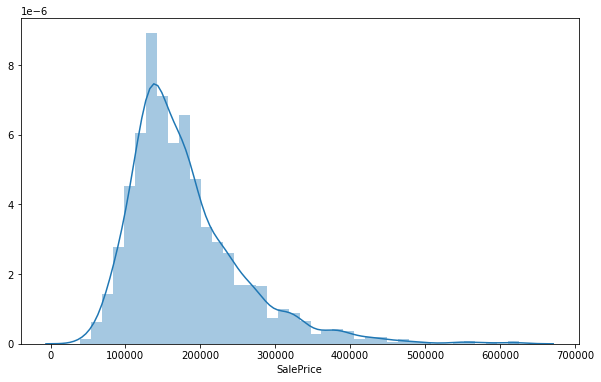

In [24]:
# SalePrice distribution
plt.figure(figsize=(10,6))
sns.distplot(train.SalePrice)
plt.show()

In [25]:
train.SalePrice.skew()

1.5975204775947223

In [26]:
train.SalePrice.kurtosis()

3.987797509850741

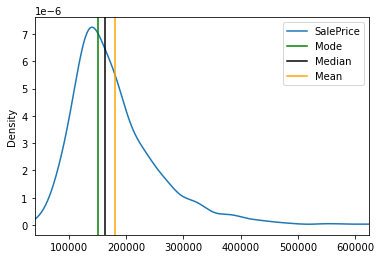

In [27]:
mean = train['SalePrice'].mean()
median = train['SalePrice'].median()

train['SalePrice'].plot.kde(xlim = (train['SalePrice'].min(),
                                     train['SalePrice'].max()
                                    )
                            )
plt.axvline(150000, color = 'Green', label = 'Mode')
plt.axvline(train['SalePrice'].median(), color = 'Black', label = 'Median')
plt.axvline(train['SalePrice'].mean(), color = 'Orange', label = 'Mean')
plt.legend()

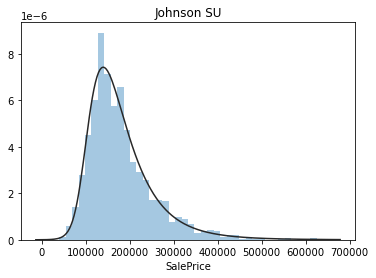

In [28]:
#Check SalePrice against Johnson SU
y = train['SalePrice']
plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)

`SalePrice` is positively skewed and shows peakness, I'll log transform this feature further along.

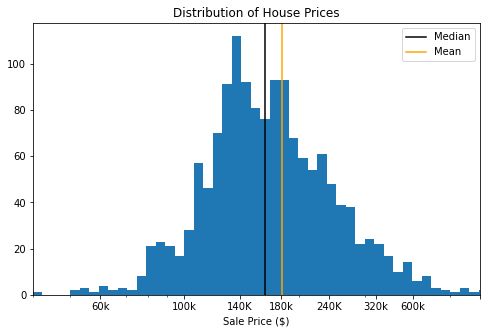

In [29]:
sale_log = np.log1p(train['SalePrice'])

log_binsize = 0.025
bins = 10 ** np.arange(3.5, sale_log.max()+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = train, x = 'SalePrice', bins = bins)
plt.title('Distribution of House Prices')
plt.xscale('log')
plt.xlim([4e4, 6e5])
plt.xticks([6e4, 1e5, 1.4e5, 1.8e5, 2.4e5, 3.2e5, 4e5, 6e5], ['60k', '100k', '140K', '180k', '240K', '320k', '600k'])
plt.xlabel('Sale Price ($)')
plt.axvline(train['SalePrice'].median(), color = 'Black', label = 'Median')
plt.axvline(train['SalePrice'].mean(), color = 'Orange', label = 'Mean')
plt.legend()
plt.show()

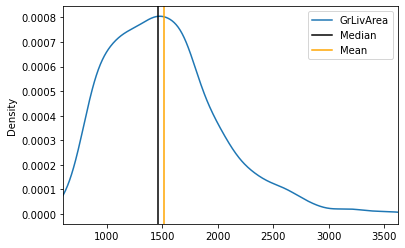

In [30]:
# Plot of above ground living area GrLivArea
mean = train['GrLivArea'].mean()
median = train['GrLivArea'].median()
train['GrLivArea'].plot.kde(xlim = (train['GrLivArea'].min(),
                                     train['GrLivArea'].max()
                                    )
                           )
plt.axvline(train['GrLivArea'].median(), color = 'Black', label = 'Median')
plt.axvline(train['GrLivArea'].mean(), color = 'Orange', label = 'Mean')
plt.legend()

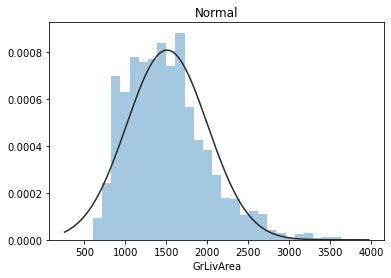

In [31]:
#Check the distribution against Normal
y = train['GrLivArea']
plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)

It's interesting to see that `GrLivArea` which represents the above grade living area in square feet has a right-skewed distribution in the dataset, it will benefit from a log transform. The median and mean show single-family homes are prevalent in the Ames market.

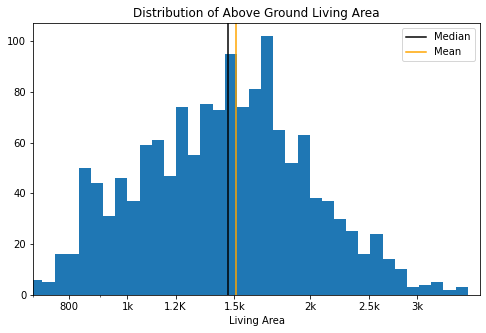

In [32]:
living_log = np.log1p(train['GrLivArea'])

log_binsize = 0.02
bins = 10 ** np.arange(2, living_log.max()+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = train, x = 'GrLivArea', bins = bins)
plt.title('Distribution of Above Ground Living Area')

plt.xscale('log')
plt.xlim([700, 3.8e3])
plt.xticks([800, 1000, 1.2e3, 1.5e3, 2e3, 2.5e3, 3e3], ['800', '1k', '1.2K', '1.5k', '2k', '2.5k', '3k'])
plt.xlabel('Living Area')
plt.axvline(train['GrLivArea'].median(), color = 'Black', label = 'Median')
plt.axvline(train['GrLivArea'].mean(), color = 'Orange', label = 'Mean')
plt.legend()

plt.show()

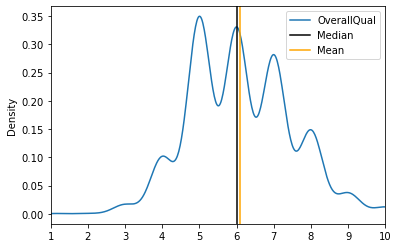

In [33]:
# Plot of OverallQual
mean = train['OverallQual'].mean()
median = train['OverallQual'].median()

train['OverallQual'].plot.kde(xlim = (train['OverallQual'].min(),
                                     train['OverallQual'].max()
                                    )
                           )
plt.axvline(train['OverallQual'].median(), color = 'Black', label = 'Median')
plt.axvline(train['OverallQual'].mean(), color = 'Orange', label = 'Mean')
plt.legend()

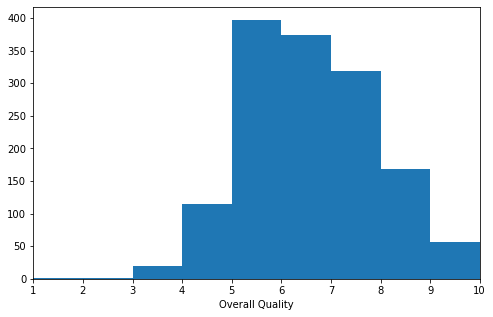

In [34]:
# plotting OverallQual on a standard scale
# Expect to have each rating in a bin
binsize = 1 
bins = np.arange(0, train['OverallQual'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = train, x = 'OverallQual', bins = bins)
plt.xlim([1,10])
plt.xlabel('Overall Quality')
plt.show()

In the case of Overall Quality, the houses in the dataset are showing a left-skewed distribution, and we have houses that are mostly Average (5) or above. I think that this is a subjective value so there's no easy transformation. I could perhaps drop the lower quality houses as I probably wouldn't be too interested in buying them, but I will leave them as-is to not apply my own bias.

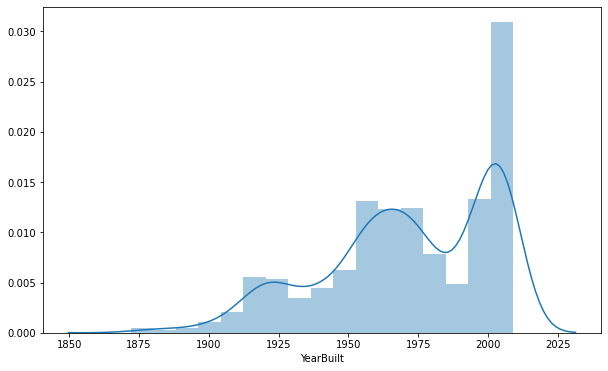

In [35]:
# YearBuilt distribution
plt.figure(figsize=(10,6))
sns.distplot(train.YearBuilt)
plt.show()

As seen earlier the houses are predominantly from post-WWII. From the distribution it almost looks like there may be a trend towards exponential growth - perhaps an opportunity for feature modeling. For the time being I will leave the data as-is.

I'll take a look at categorical features next. I'd like to have a better sense of which feature influences `SalePrice` more than others. I plan to use one-way ANOVA tests for each categorical feature.

ANOVA test
 - Ho: There exists no significant difference between the groups.
 - Ha: There exists a significant difference between the groups.

I'll make a function which calculates p values. Using the p values, I can calculate a disparity score. The higher the disparity score, the better the feature will be in predicting sale price.
For this function to work I'll need to handle missing values:

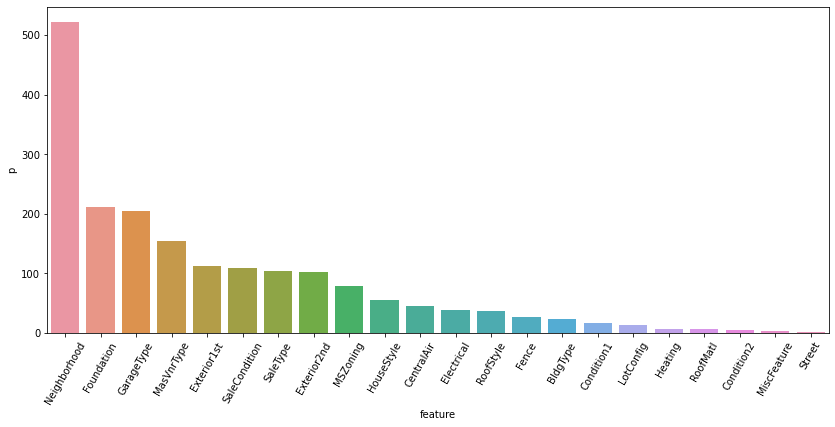

In [36]:
# find most important categorical features with relation to SalePrice
category_data = train.select_dtypes(exclude=[np.number])

anova = {'feature':[], 'f':[], 'p':[]}
for cat in cat_features:
    group_prices = []
    for group in train[cat].unique():
        group_prices.append(train[train[cat] == group]['SalePrice'].values)
    f, p = st.f_oneway(*group_prices)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
anova = pd.DataFrame(anova)
anova = anova[['feature','f','p']]
anova.sort_values('p', inplace=True)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(anova.feature, np.log(1./anova['p']))
plt.xticks(rotation=60)
plt.show()

Since neighborhood is orders of magnitude above the rest, I will first look at those values.

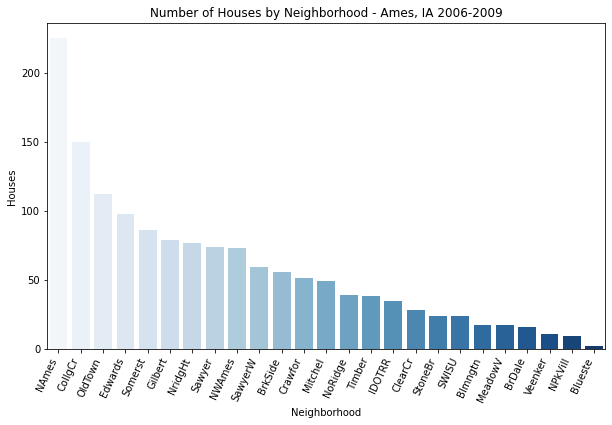

In [37]:
# plotting number of houses sold by neighborhood

plt.figure(figsize=(10,6))
plt.title('Number of Houses by Neighborhood - Ames, IA 2006-2009')

# Applying custom categorical order

sns.countplot(x = 'Neighborhood',
              data = train,
              palette = 'Blues',
              order = train['Neighborhood'].value_counts().index)
plt.ylabel('Houses')
plt.xticks(rotation=65, horizontalalignment='right')
plt.show()

Since zoning is related to neighborhood, I've decided to look at that. The building zones in Ames for the dataset represent what type of housing is permitted. 

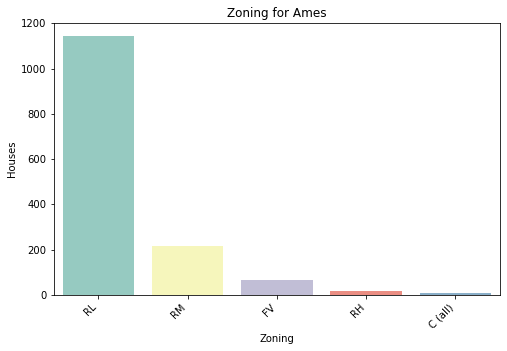

In [38]:
# plotting number of zones

plt.figure(figsize=(8,5))
plt.title('Zoning for Ames')

sns.countplot(x ='MSZoning',
              data=train,
              palette='Set3',
              order=train['MSZoning'].value_counts().index)
plt.ylabel('Houses')
plt.xlabel('Zoning')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

`SalePrice` is right-skewed and prior to removing the outliers shows some peakness. As it doesn't follow normal distribution it requires log transformation before performing regression. 

Also positively skewed to the right similar to `SalePrice` and requiring log tranformation is `GrLivArea`. 

`OverallQual` is left-skewed however as it expresses the quality of the homes being sold I will leave it as is.

`YearBuilt` is right-skewed and shows a tendency for exponential growth over the time frame studied.

`Neighborhood` shows higher volume of sales in North Ames and College Creek, I will assume for now that these are popular locations. It could be also that more new development was taking place in some of the areas which would drive housing sales.

`MSZoning` shows that the majority of the houses in the data set are Residential Low Density (RL), it will be interesting to see what the correlation is, if any, for the neighborhoods in Ames.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

`OverallQual` shows a tendency for houses in this dataset to have overall Average or better ratings, this may mean that either most houses being sold are of Average quality (a perfectly viable assumption) and/or the person assessing the property might have some motivation to give these ratings (completely unknown and unsafe to base our analysis on.) I left the data as is.

The living area expressed in `GrLivArea` is a valuation of the houses being sold in the market. 

I transformed `MoSold`, `YrSold` and `MSSubclass` to categorical variables for future use. 

For categorical variables, I made a transformation for the following features to normalize ranking data on a numerical scale: `Alley`, `LotShape`, `LandContour`, `Utilities`, `LandSlope`, `ExterQual`, `ExterCond`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `HeatingQC`, `KitchenQual`, `Functional`, `FireplaceQu`, `GarageFinish`, `GarageQuality`, `GarageCond`, `PavedDrive`, `PoolQC`.

## Bivariate Exploration

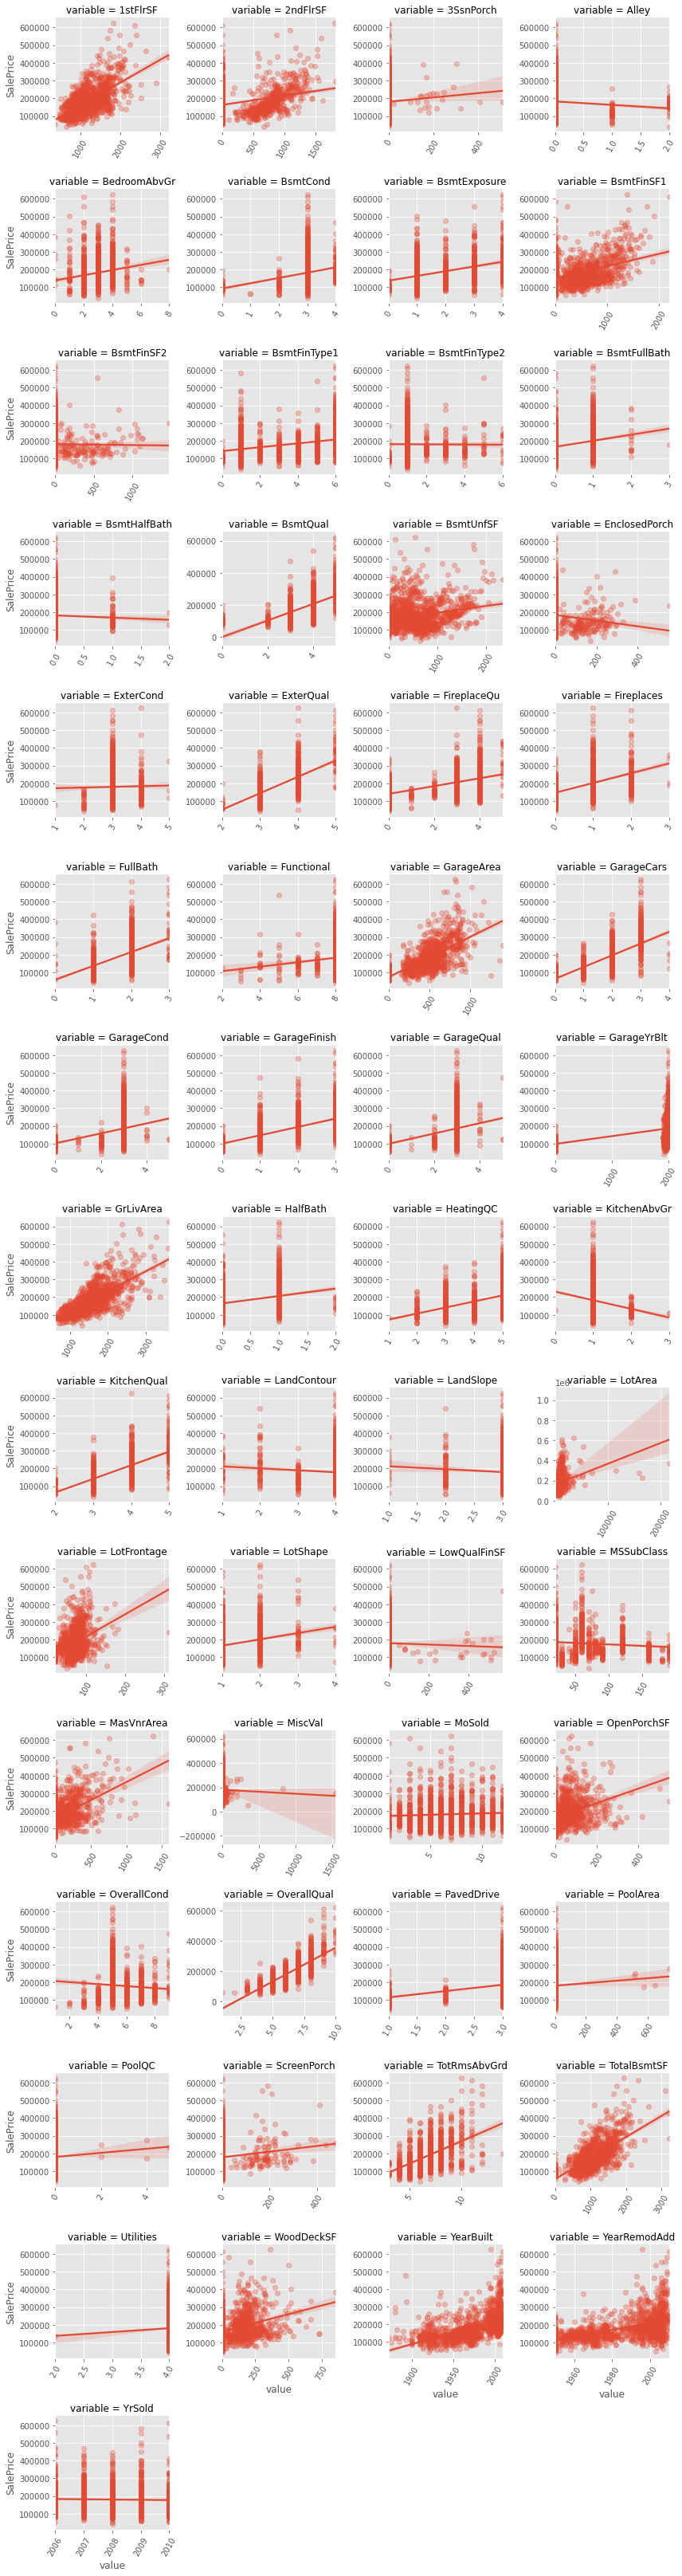

In [55]:
# Scatter plots of numerical features against SalePrice
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

I observe that a number of features show high correlation to `SalePrice`, such as `OverallQual`, and `GrLivArea`. It is fairly intuitive to expect higher sale prices for houses with larger living areas, and higher overall quality. 

Next I'll plot a heatmap to see the correlation between numerical features.

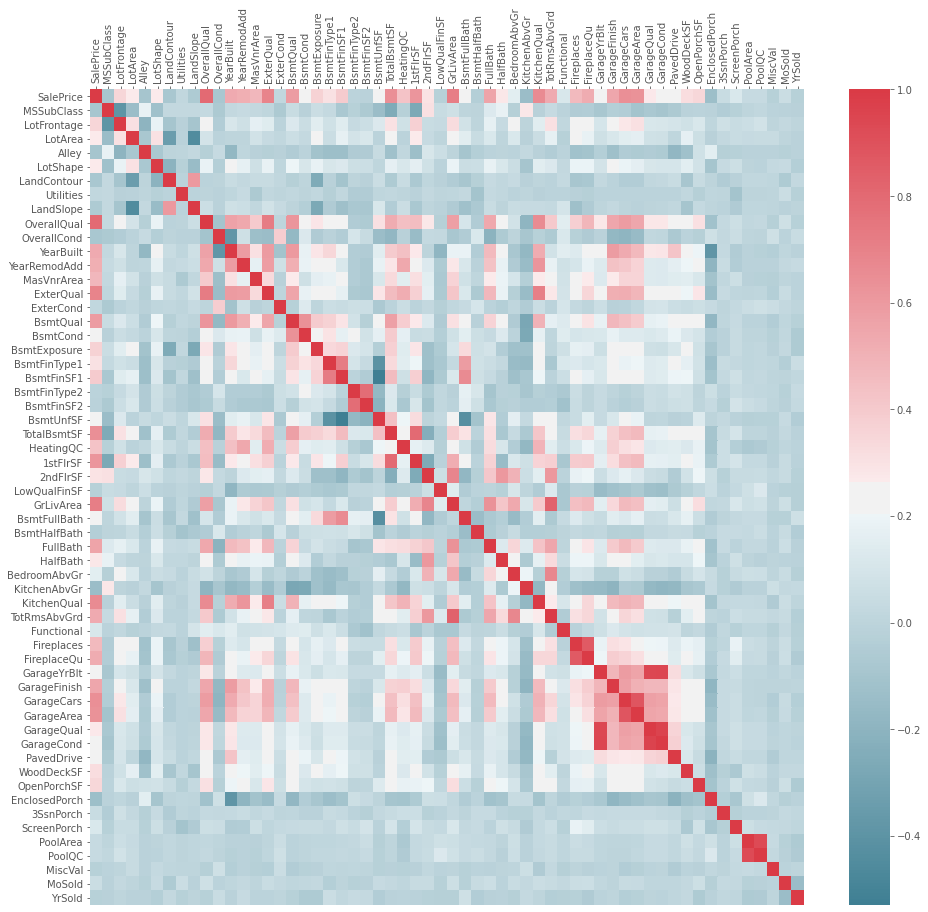

In [56]:
#correlation between all numerical features
corr = train[['SalePrice'] + num_features].corr()
fig = plt.figure(figsize=(16,15))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

I'd like to know how these numerical features correlate with `SalePrice`. 

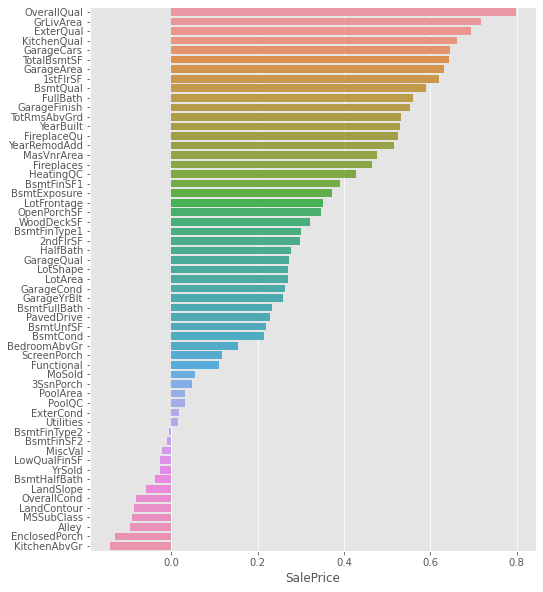

In [57]:
# Numerical features sorted with correlation to SalePrice
corr = corr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()

Of the numerical features correlated with `SalePrice`, `OverallQual` is closest followed by `GrLivArea`.

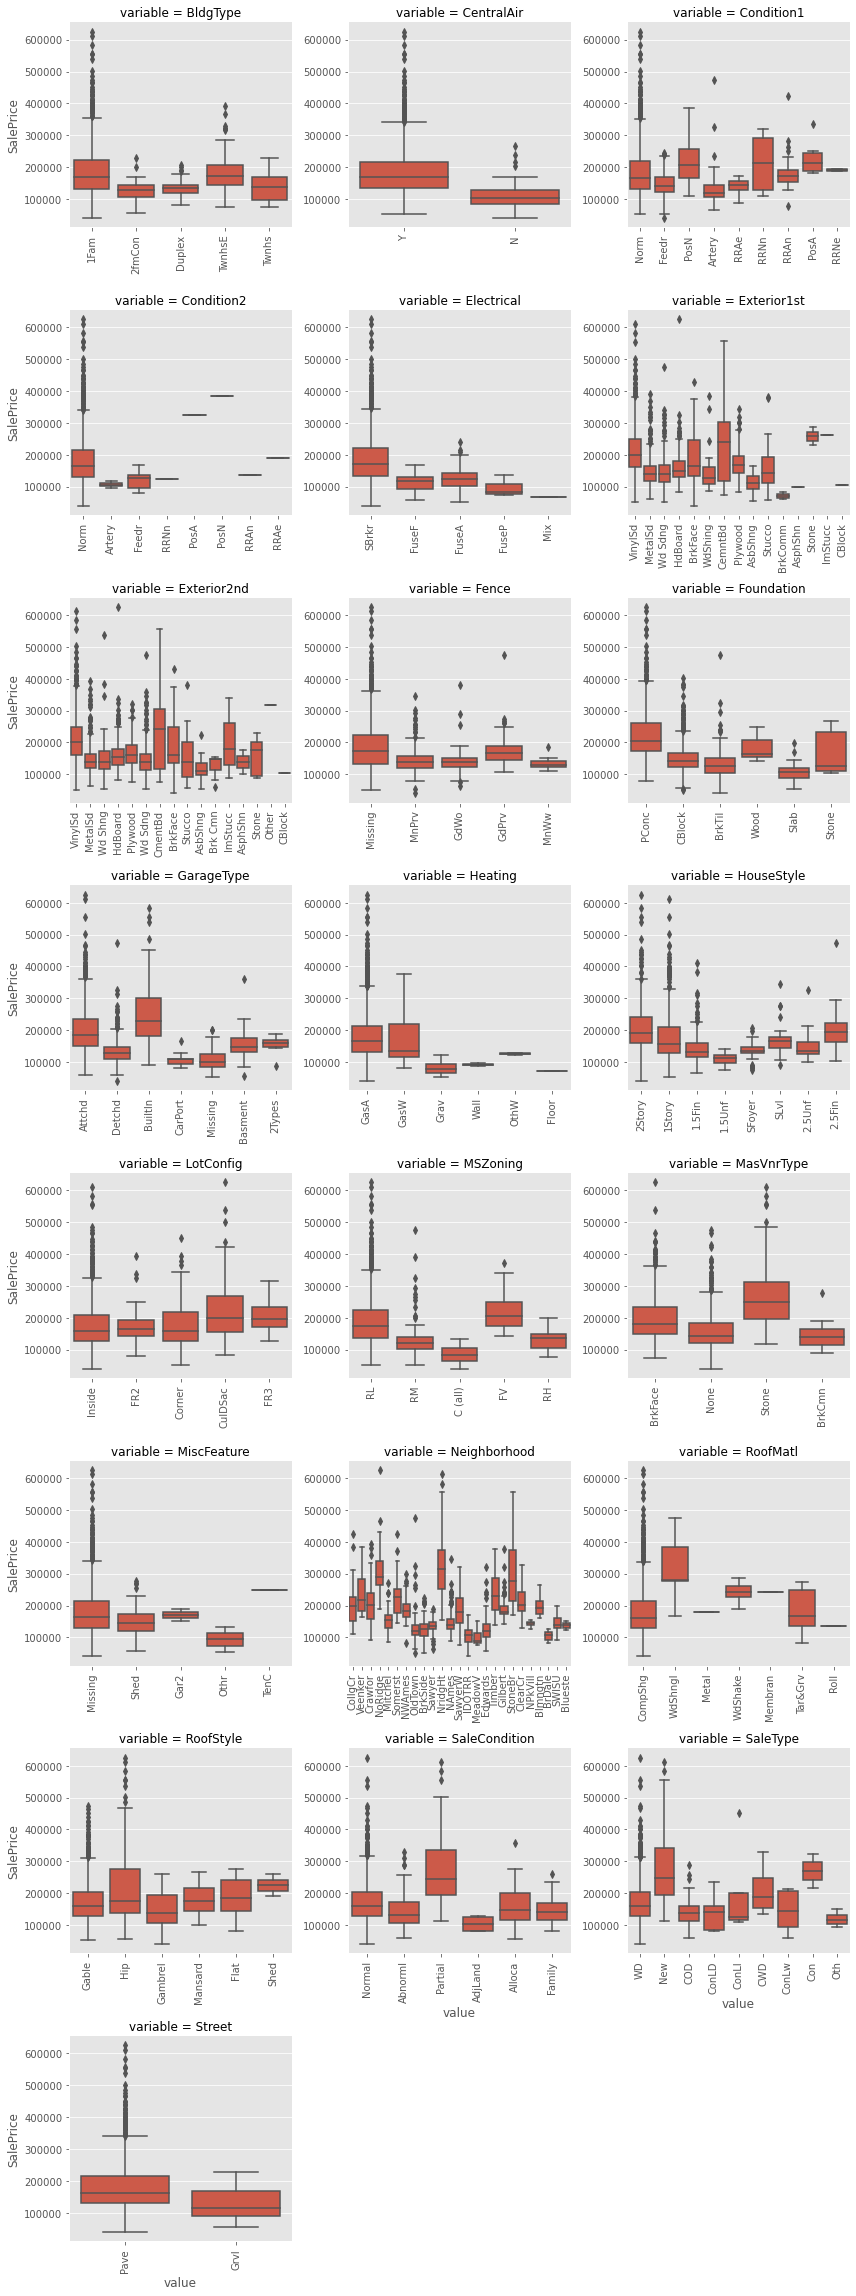

In [58]:
# Count plots of categorical features
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

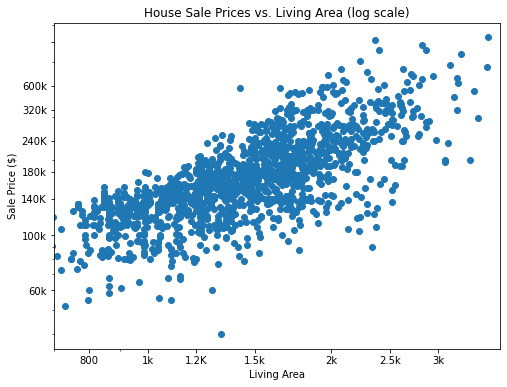

In [39]:
# Living Area vs. Sale Price
plt.figure(figsize = [8, 6])
plt.scatter(data = train, x = 'GrLivArea', y = 'SalePrice')

plt.title('House Sale Prices vs. Living Area (log scale)')
plt.xscale('log')
plt.xticks([800, 1000, 1.2e3, 1.5e3, 2e3, 2.5e3, 3e3], ['800', '1k', '1.2K', '1.5k', '2k', '2.5k', '3k'])
plt.xlim([700, 3.8e3])
plt.xlabel('Living Area')

plt.yscale('log')
plt.yticks([6e4, 1e5, 1.4e5, 1.8e5, 2.4e5, 3.2e5, 4e5, 6e5], ['60k', '100k', '140K', '180k', '240K', '320k', '600k'])
plt.ylabel('Sale Price ($)')

plt.show()

Plotting sales price versus living area (both log scale) looks like a near linear relationship 

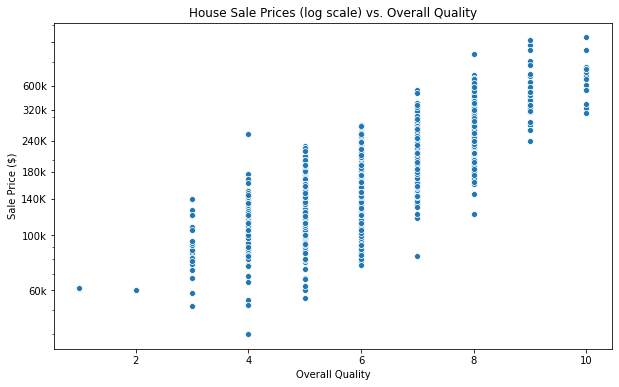

In [42]:
# Overall Quality vs. SalePrice
plt.figure(figsize = [10, 6])
sns.scatterplot('OverallQual','SalePrice', data = train)

plt.title('House Sale Prices (log scale) vs. Overall Quality')
plt.xlabel('Overall Quality')
plt.yscale('log')
plt.yticks([6e4, 1e5, 1.4e5, 1.8e5, 2.4e5, 3.2e5, 4e5, 6e5], ['60k', '100k', '140K', '180k', '240K', '320k', '600k'])
plt.ylabel('Sale Price ($)')
plt.show()

Plotting the sale price vs. overall quality shows a trend towards higher prices for higher quality ratings, which is not surprising

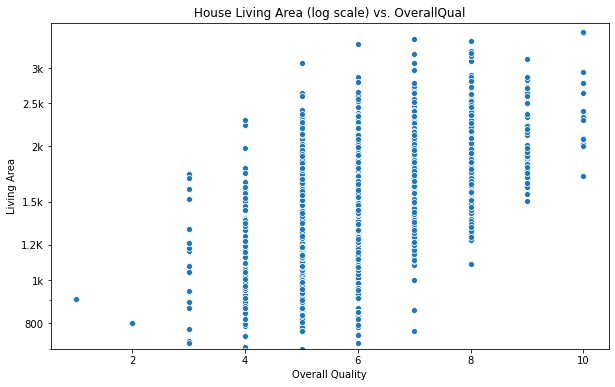

In [44]:
# Living area vs. overall quality 
plt.figure(figsize = [10, 6])
sns.scatterplot(x='OverallQual', y='GrLivArea',data=train)

plt.title('House Living Area (log scale) vs. OverallQual')
plt.xlabel('Overall Quality')
plt.yscale('log')
plt.yticks([800, 1000, 1.2e3, 1.5e3, 2e3, 2.5e3, 3e3], ['800', '1k', '1.2K', '1.5k', '2k', '2.5k', '3k'])
plt.ylim([700, 3.8e3])
plt.ylabel('Living Area')
plt.show()

Plotting living area vs. Overall Quality shows that generally the trend is for larger houses to have higher quality ratings

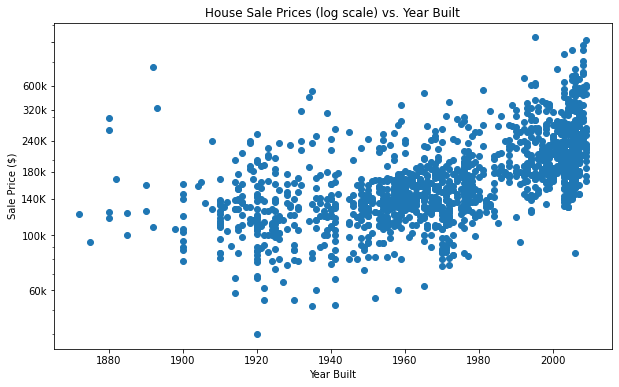

In [45]:
plt.figure(figsize = [10, 6])
plt.scatter(data = train, x = 'YearBuilt', y = 'SalePrice')

plt.title('House Sale Prices (log scale) vs. Year Built')
plt.xlabel('Year Built')
plt.xticks([1880, 1900, 1920, 1940, 1960, 1980, 2000], ['1880', '1900', '1920', '1940', '1960', '1980', '2000'])
plt.yscale('log')
plt.yticks([6e4, 1e5, 1.4e5, 1.8e5, 2.4e5, 3.2e5, 4e5, 6e5], ['60k', '100k', '140K', '180k', '240K', '320k', '600k'])
plt.ylabel('Sale Price ($)')
plt.show()

Plotting sales price on a log scale versus year built shows higher prices for newer homes. There's less data for houses pre-WWII.

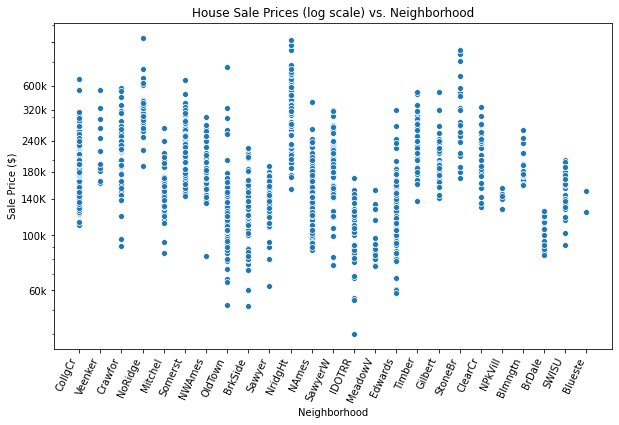

In [46]:
# SalePrice by neighborhood
plt.figure(figsize = [10, 6])
sns.scatterplot(x='Neighborhood', y='SalePrice',data=train)

plt.title('House Sale Prices (log scale) vs. Neighborhood')
plt.xlabel('Neighborhood')
plt.xticks(rotation=65, horizontalalignment='right')
plt.yscale('log')
plt.yticks([6e4, 1e5, 1.4e5, 1.8e5, 2.4e5, 3.2e5, 4e5, 6e5], ['60k', '100k', '140K', '180k', '240K', '320k', '600k'])
plt.ylabel('Sale Price ($)')
plt.show()

There are some neighborhoods that exhibit higher prices, it would be interesting to have further background information. I'll take a look at the development for the neighborhoods using the `YearBuilt` feature, and `GrLivArea` as a dummy variable to create a heatmap.

In [47]:
# Limit the data to houses newer than 1950
Year = train.drop(train[(train.YearBuilt < 1950)].index)

x = train['GrLivArea']
by_neighbor = (Year
            .groupby('Neighborhood')
            .filter(lambda x : len(x) > 10)
            .groupby(['Neighborhood', 'YearBuilt'])
            .size()
            .unstack()
           )

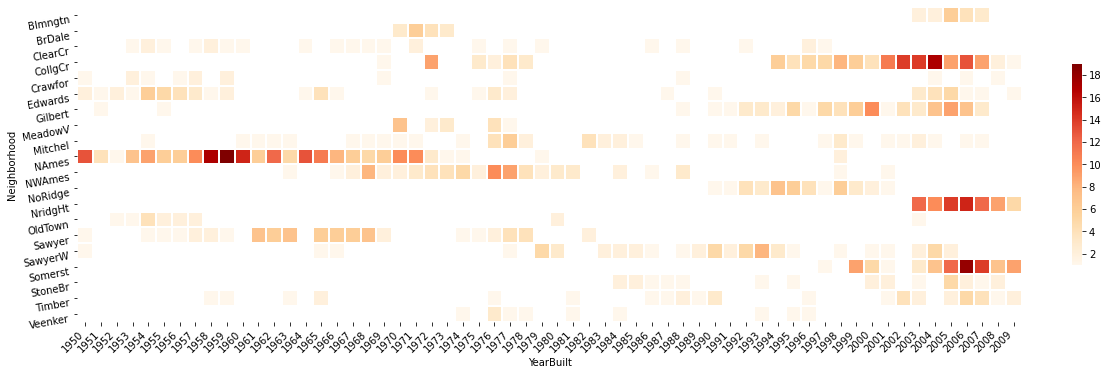

In [48]:
plt.figure(figsize=(18,30))

g = sns.heatmap(
    by_neighbor, 
    square=True, # make cells square
    
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)
plt.yticks(rotation=10, verticalalignment='top')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

This gives me some insight into the development phases in the Ames neighborhoods by year, which is really interesting!

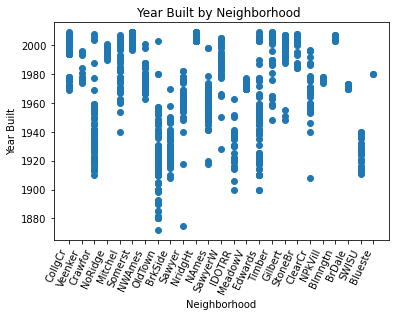

In [49]:
# Neighborhood by year built
plt.scatter(train['Neighborhood'], train['YearBuilt'])
plt.title("Year Built by Neighborhood ")
plt.ylabel("Year Built")
plt.xlabel("Neighborhood")
plt.xticks(rotation=65, horizontalalignment='right')
plt.show()

Above is a more generalized view using a scatterplot

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

For numerical features `OverallQual` is most closely related to `SalesPrice`, followed by `GrLivArea`. 
Among categorical features `Neighborhood` shows significant variance in the mean `SalePrice`. `Neighborhood` is the categorical feature that has the greatest influence on `SalePrice` for this dataset and appears to be a good variable to predict `SalePrice`. `MSZoning` gives us some information about the types of housing in the neighborhood.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Graphing `YearBuilt` vs. `Neighborhood` allowed me to see yearly trends by neighborhood, and `GrLivArea` vs. `Neighborhood` the home size trends by neighborhood.


## Multivariate Exploration

Sales Price by Neighborhood and Zoning

One possible method to understand sales price by neighborhood is to classify the values by the building zones:

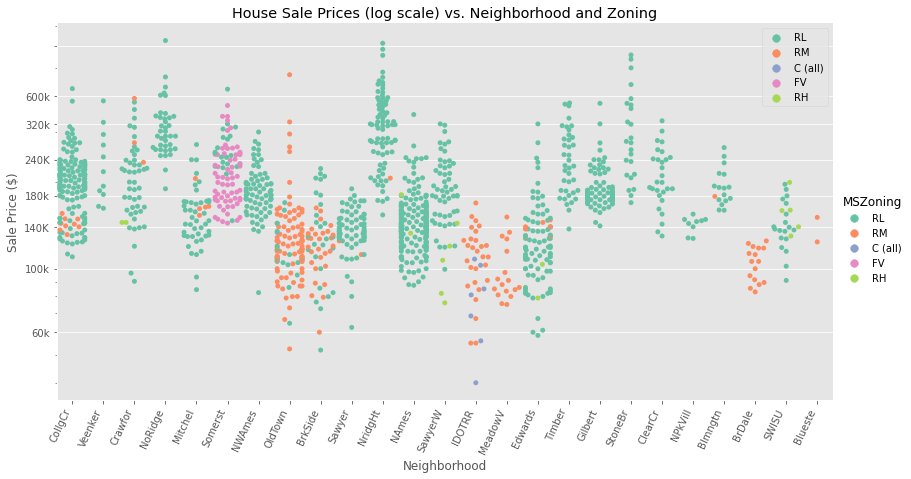

In [52]:
# Sale price by neighborhood using zoning to define areas
plt.style.use('ggplot')
g = sns.catplot(
    x = 'Neighborhood',
    y = 'SalePrice',
    data = train,
    kind='swarm',
    hue='MSZoning',
    palette = 'Set2', 
    height=6, 
    aspect=2
)

plt.title('House Sale Prices (log scale) vs. Neighborhood and Zoning')
plt.xticks(rotation=65, horizontalalignment='right')
plt.xlabel('Neighborhood')
plt.yscale('log')
plt.yticks([6e4, 1e5, 1.4e5, 1.8e5, 2.4e5, 3.2e5, 4e5, 6e5], ['60k', '100k', '140K', '180k', '240K', '320k', '600k'])
plt.ylabel('Sale Price ($)')
plt.legend()
plt.show()

This reinforces our finding that the zoning does not play a significant role in predicting the sale price for all houses, as suggested before the prevalent value is `RL` (Residential Low Density). It might be more useful for particular neighborhoods such as `Sommerst`or `BrkSide`.

Sale price by year built and overall quality

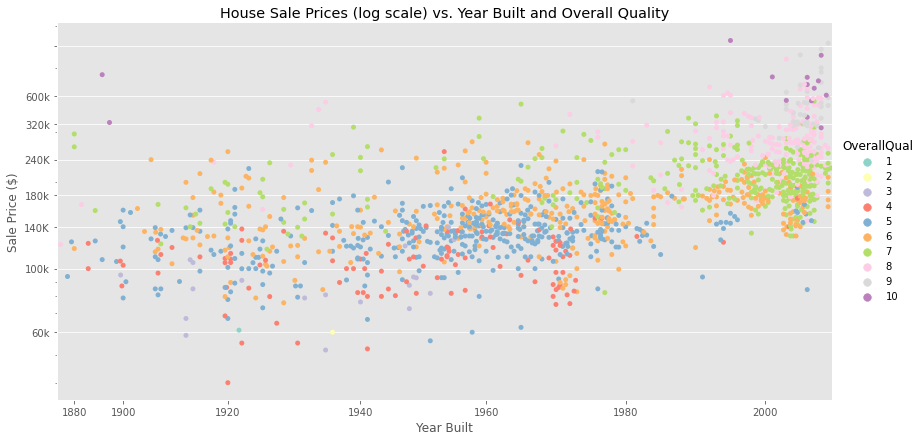

In [54]:
#List of only the index locations for the years to be used as labels
xticks = [2, 9, 24, 43, 61, 81, 101]

plt.style.use('ggplot')
g = sns.catplot(
    x = 'YearBuilt',
    y = 'SalePrice',
    data = train,
    kind='swarm',
    hue='OverallQual',
    palette = 'Set3', height=6, aspect=2)

plt.title('House Sale Prices (log scale) vs. Year Built and Overall Quality')
plt.xticks(xticks, ['1880', '1900', '1920', '1940', '1960', '1980', '2000'])
plt.xlabel('Year Built')
plt.yscale('log')
plt.yticks([6e4, 1e5, 1.4e5, 1.8e5, 2.4e5, 3.2e5, 4e5, 6e5], ['60k', '100k', '140K', '180k', '240K', '320k', '600k'])
plt.ylabel('Sale Price ($)')
plt.show()

### Resources

The following Kaggle kernels where helpful in understanding the dataset further, and for some idea generation:
- [Housing prices EDA](https://www.kaggle.com/dgawlik/house-prices-eda)
- [A study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)
- [Comprehensive data exploration with python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

General Resources:

- [Johnson SU distribution](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.johnsonsu.html)
- [Seaborn heatmaps](https://www.drawingfromdata.com/how-to-rotate-axis-labels-in-seaborn-and-matplotlib)
- [Seaborn categorical swarmplot](https://seaborn.pydata.org/generated/seaborn.catplot.html)

- [Pardoe , I. (2008), “Modeling home prices using realtor data”, Journal of Statistics Education Volume 16, Number 2 (2008)](http://jse.amstat.org/v16n2/datasets.pardoe.html)